In [1]:
import os
import sys
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pprint import pprint

from skimage.color import label2rgb

import torch
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler

from sklearn.model_selection import train_test_split

import albumentations as A

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

from tqdm.auto import tqdm

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from importlib import reload
sys.path.append('../modules/')
from segmentation import processing as sp
from segmentation import dataset
from segmentation import model

from tools import viz
from tools import typing
from tools import image

## Read metadata, find files

In [5]:
td = pd.read_csv('../../for_segmentation/TrainingDataSet250.csv')
print(len(td), len(td['ORF Name'].unique()))
td.head()

250 250


,ORF Name,384Plate,384Row,384Column
0,YLR422W,1,1,19
1,YDR217C,1,1,20
2,YGR100W,1,2,10
3,YCR033W,1,3,12
4,YNL250W,1,3,20


In [57]:
img.shape

(1001, 1339)

In [61]:
orf, orf_counts = np.unique([f.split('/')[-1].split('_')[0] for f in fn_flex], return_counts=True)
orf[orf_counts != 10], orf_counts[orf_counts != 10] 

(array(['YPR156C'], dtype='<U9'), array([6]))

In [19]:
fn_flex = sorted(glob.glob('../../for_segmentation/Flex/Plate */*'))
fn_label = sorted(glob.glob('../../for_segmentation/LabelImages/*/*.npy'))

print(len(fn_flex), len(fn_label))
pprint(fn_flex[:5])
pprint(fn_label[:5])

2496 2496
['../../for_segmentation/Flex/Plate 1/YCR033W_003012001.flex',
 '../../for_segmentation/Flex/Plate 1/YCR033W_003012002.flex',
 '../../for_segmentation/Flex/Plate 1/YCR033W_003012003.flex',
 '../../for_segmentation/Flex/Plate 1/YCR033W_003012004.flex',
 '../../for_segmentation/Flex/Plate 1/YCR033W_003012005.flex']
['../../for_segmentation/LabelImages/R2_Plate_1/YCR033W_003012001_1.npy',
 '../../for_segmentation/LabelImages/R2_Plate_1/YCR033W_003012002_1.npy',
 '../../for_segmentation/LabelImages/R2_Plate_1/YCR033W_003012003_1.npy',
 '../../for_segmentation/LabelImages/R2_Plate_1/YCR033W_003012004_1.npy',
 '../../for_segmentation/LabelImages/R2_Plate_1/YCR033W_003012005_1.npy']


## Check appearance

In [87]:
img_idx = 301

In [92]:
fn_flex[img_idx]

'../../for_segmentation/Flex/Plate 10/YDR011W_005021002.flex'

In [88]:
%%time
img = np.array(Image.open(fn_flex[img_idx]))

CPU times: user 2.09 ms, sys: 12.6 ms, total: 14.7 ms
Wall time: 109 ms


In [89]:
%%time
seg = np.load(fn_label[img_idx])

CPU times: user 650 µs, sys: 11.2 ms, total: 11.9 ms
Wall time: 116 ms


In [132]:
reload(sp)

<module 'segmentation.processing' from '../modules/segmentation/processing.py'>

In [135]:
%%time
seg_dt = sp.make_distance_transform(seg, scale_by_stencil=False)

CPU times: user 1.43 s, sys: 21 ms, total: 1.45 s
Wall time: 1.45 s


In [112]:
reload(viz)

<module 'tools.viz' from '../modules/tools/viz.py'>

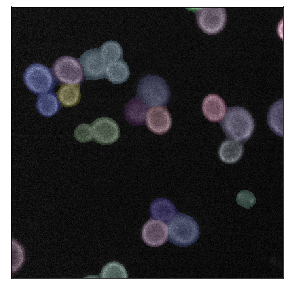

In [105]:
viz.plot_segmentation_overlay(img, seg, (100, 100, 400))

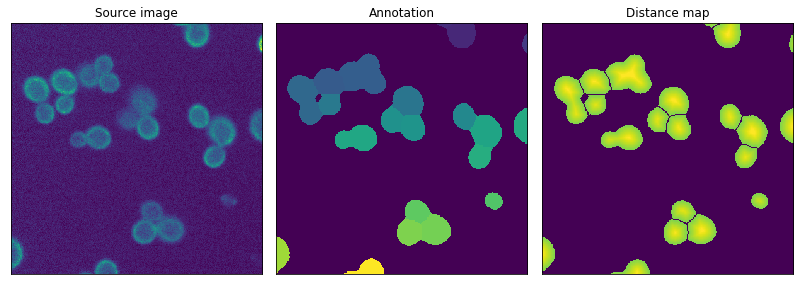

In [114]:
viz.plot_by_side([img, seg, seg_dt], ['Source image', 'Annotation', 'Distance map'], crop_parameters=(100, 100, 400))

Visualize difference between binary and distance map

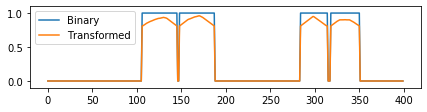

In [140]:
fig, ax = plt.subplots(ncols=1, figsize=(7, 1.5))
ax.plot((seg_dt[100:500, 100:500] > 0).astype(int)[:, 220], label='Binary')
ax.plot(seg_dt[100:500, 100:500][:, 220], label='Transformed')
ax.set_ylim((-0.1,1.1))
plt.legend()
plt.show()

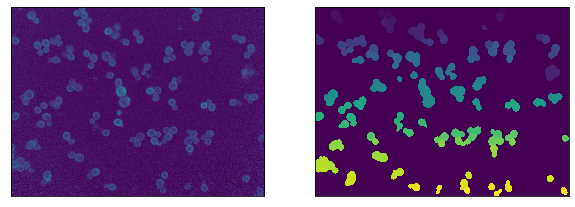

In [93]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].imshow(img)
ax[1].imshow(seg)
viz.clean_show(ax)

# Training

In [4]:
# setup train transforms
transforms = A.Compose([
    A.RandomCrop(256, 256),
    A.RandomRotate90(),
])

In [56]:
%%time
reload(dataset)
reload(image)
ads = dataset.AnnotatedDataset(log=True, transforms=transforms)

# make stratified validation split (1 image per gene, 250 in total)
indices = np.arange(len(ads))
train_idx, valid_idx = train_test_split(indices, test_size=0.1, random_state=65, shuffle=True, 
                                      stratify=ads.metainfo.gene.tolist())

print(f'train {len(train_idx)}, valid {len(valid_idx)} (unique genes {ads.metainfo.gene[valid_idx].nunique()})')

train 2246, valid 250 (unique genes 250)
CPU times: user 83.4 ms, sys: 35.8 ms, total: 119 ms
Wall time: 854 ms


In [57]:
ads.eval()

In [58]:
train_loader = DataLoader(ads, batch_size=32, num_workers=16, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(ads, batch_size=1, num_workers=4, sampler=SubsetRandomSampler(valid_idx))

len(train_loader), len(valid_loader)

(71, 250)

In [59]:
%%time
img, seg = ads[0]
img.shape, seg.shape

CPU times: user 1.31 s, sys: 34.6 ms, total: 1.34 s
Wall time: 267 ms


(torch.Size([1, 1024, 1344]), torch.Size([1, 1024, 1344]))

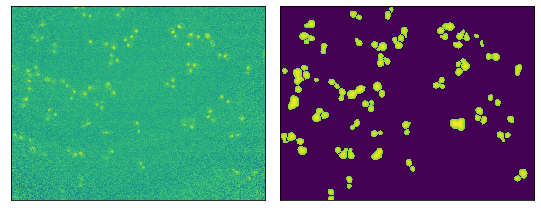

In [60]:
viz.plot_by_side([img[0], seg[0]])

In [10]:
wandb_logger = WandbLogger(project='yeast-protein-loc')
trainer = Trainer(logger=wandb_logger, gpus=1, max_epochs=200, )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [1]


In [26]:
reload(model)
segmentation_model = model.SegmentationModel()

In [12]:
trainer.fit(segmentation_model, train_loader, valid_loader)

wandb: Currently logged in as: papkov (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200921_154032-3p0yymah
wandb: Syncing run misunderstood-dust-3



  | Name      | Type     | Params
---------------------------------------
0 | network   | Unet     | 24 M  
1 | criterion | BCELoss  | 0     
2 | accuracy  | Accuracy | 0     


/gpfs/hpc/home/papkov/.conda/envs/peenv36/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 2 number of classes if different from predicted (1) and target (1) number of classes
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

In [27]:
ckpt = torch.load('./yeast-protein-loc/3p0yymah/checkpoints/epoch=138.ckpt')
segmentation_model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [28]:
valid_predictions, valid_ys = segmentation_model.inference(valid_loader)

/gpfs/hpc/home/papkov/.conda/envs/peenv36/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 1 number of classes if different from predicted (2) and target (2) number of classes
  warnings.warn(*args, **kwargs)
/gpfs/hpc/home/papkov/.conda/envs/peenv36/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 1 number of classes if different from predicted (1) and target (2) number of classes
  warnings.warn(*args, **kwargs)
/gpfs/hpc/home/papkov/.conda/envs/peenv36/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 1 number of classes if different from predicted (2) and target (1) number of classes
  warnings.warn(*args, **kwargs)


Show watershed results

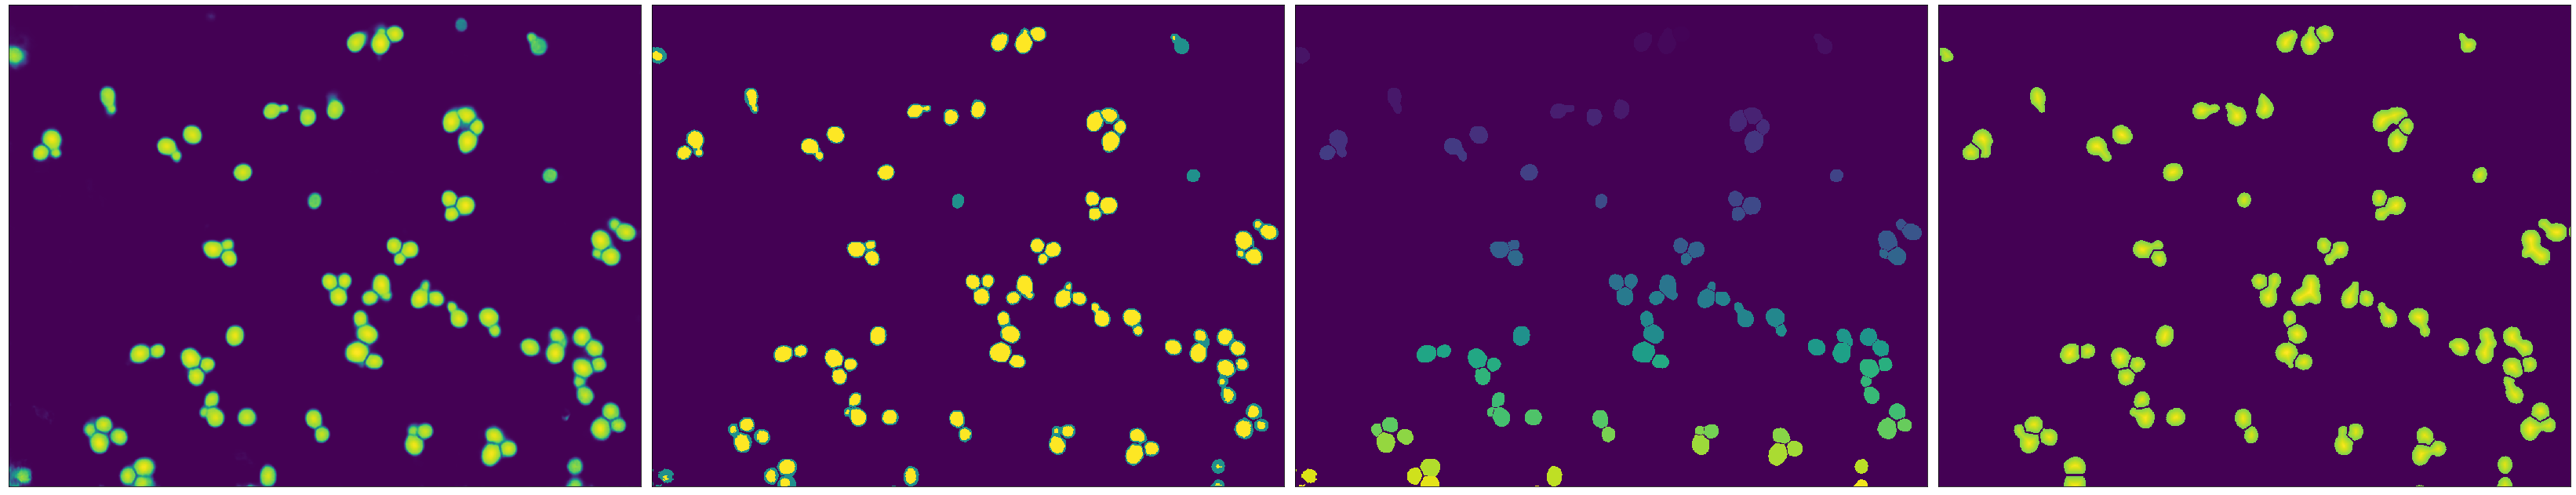

In [141]:
viz.plot_by_side([valid_predictions[20,0],
                  (valid_predictions[20,0] > 0.5).astype(int) + (valid_predictions[20,0] > 0.8).astype(int), 
                  sp.watershed_distance_map(valid_predictions[20,0]),
                  valid_ys[20,0]], size=15)

## Prediction

In [81]:
reload(dataset)
eds = dataset.ExperimentDataset()

Segmentation for experiment dataset is not available

torch.Size([1, 1024, 1344]) torch.Size([1, 1024, 1344])


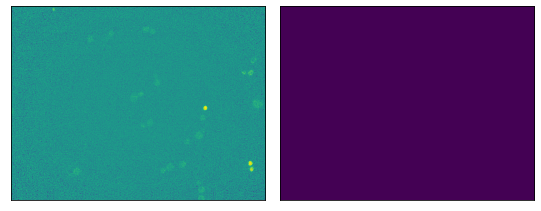

CPU times: user 2.17 s, sys: 200 ms, total: 2.37 s
Wall time: 272 ms


In [83]:
%%time
img, seg = eds[20]
print(img.shape, seg.shape)
viz.plot_by_side([img[0], seg[0]])

Compare backgroung patterns in two datasets

In [72]:
reload(viz)

<module 'tools.viz' from '../modules/tools/viz.py'>

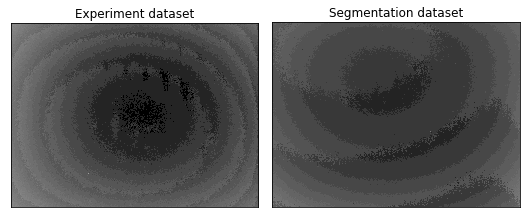

In [75]:
viz.plot_by_side([
    image.log_transform_scale(eds.background),
    image.log_transform_scale(ads.background)
], titles=['Experiment dataset', 'Segmentation dataset'], cmap='gray')